In [66]:
# Improved RwandanFoodAI.ipynb

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [67]:
# Set up paths
BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, "Dataset", "Rwandandishies")
NUTRITION_DATA_PATH = os.path.join(BASE_DIR, "data", "nutrition", "rwandan_food_data.csv")
MODEL_PATH = os.path.join(BASE_DIR, "models", "rwandan_food_model.h5")

In [68]:
# Load the CSV data
df = pd.read_csv(NUTRITION_DATA_PATH)

In [69]:
# 1. Dataset Overview
print(f"Total number of dishes: {len(df)}")
print(f"Columns in the dataset: {', '.join(df.columns)}")

Total number of dishes: 24
Columns in the dataset: name, ingredients, total_calories, protein, carbs, fat, fiber, sodium, sugar


In [70]:
# 1. Dataset Overview
print(f"Total number of dishes: {len(df)}")
print(f"Columns in the dataset: {', '.join(df.columns)}")

Total number of dishes: 24
Columns in the dataset: name, ingredients, total_calories, protein, carbs, fat, fiber, sodium, sugar


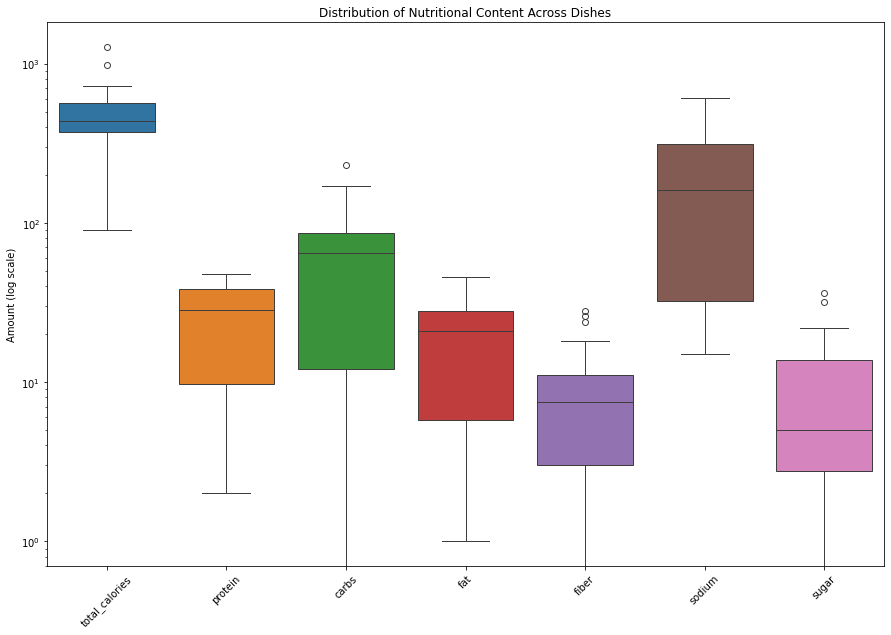

In [71]:
# 2. Nutritional Content Distribution
plt.figure(figsize=(15, 10))
sns.boxplot(data=df[['total_calories', 'protein', 'carbs', 'fat', 'fiber', 'sodium', 'sugar']])
plt.title('Distribution of Nutritional Content Across Dishes')
plt.yscale('log')
plt.ylabel('Amount (log scale)')
plt.xticks(rotation=45)
plt.show()

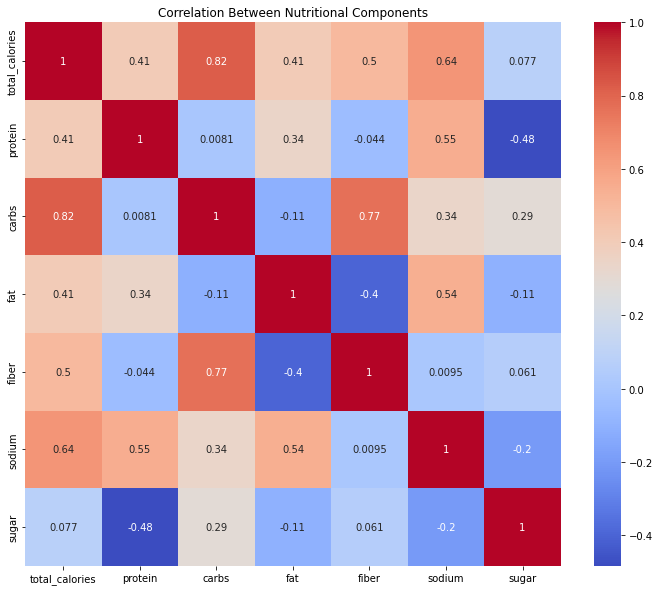

In [72]:
# 3. Correlation Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df[['total_calories', 'protein', 'carbs', 'fat', 'fiber', 'sodium', 'sugar']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Between Nutritional Components')
plt.show()

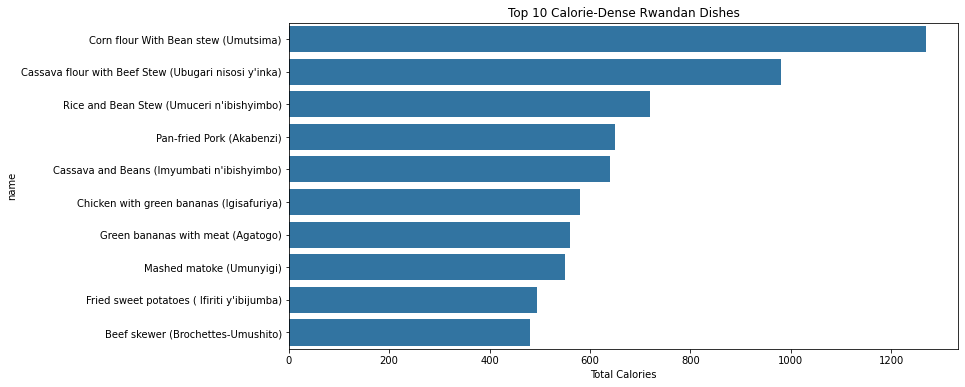

In [73]:
# 4. Top 10 Calorie-Dense Dishes
plt.figure(figsize=(12, 6))
top_10_calories = df.nlargest(10, 'total_calories')
sns.barplot(x='total_calories', y='name', data=top_10_calories)
plt.title('Top 10 Calorie-Dense Rwandan Dishes')
plt.xlabel('Total Calories')
plt.show()

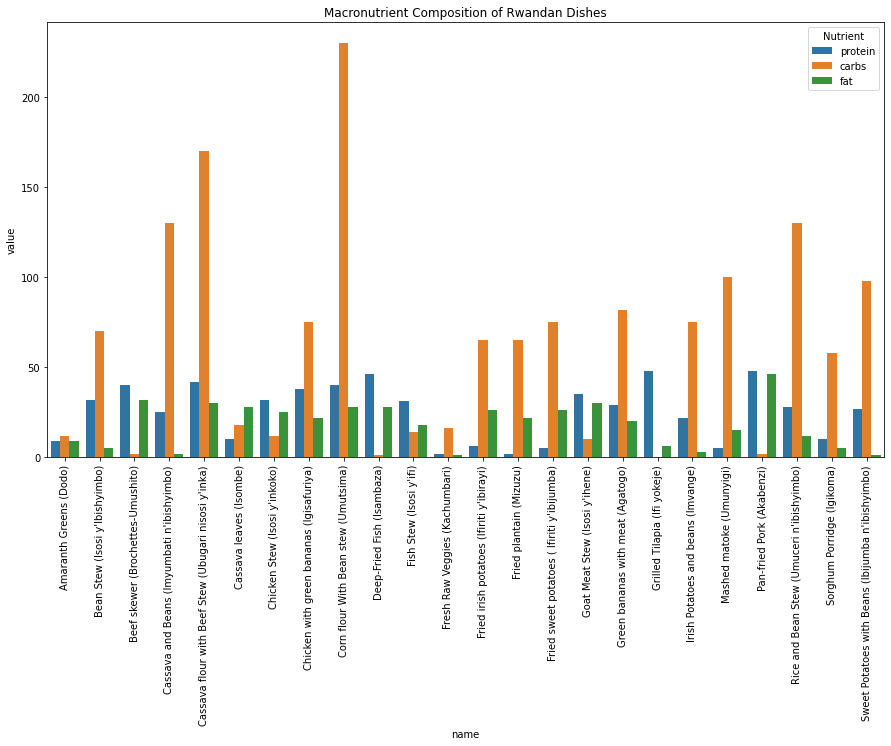

In [74]:
# 5. Macronutrient Composition
plt.figure(figsize=(15, 8))
macronutrients = df[['name', 'protein', 'carbs', 'fat']]
macronutrients_stacked = macronutrients.set_index('name').stack().reset_index()
macronutrients_stacked.columns = ['name', 'nutrient', 'value']
sns.barplot(x='name', y='value', hue='nutrient', data=macronutrients_stacked)
plt.title('Macronutrient Composition of Rwandan Dishes')
plt.xticks(rotation=90)
plt.legend(title='Nutrient')
plt.show()

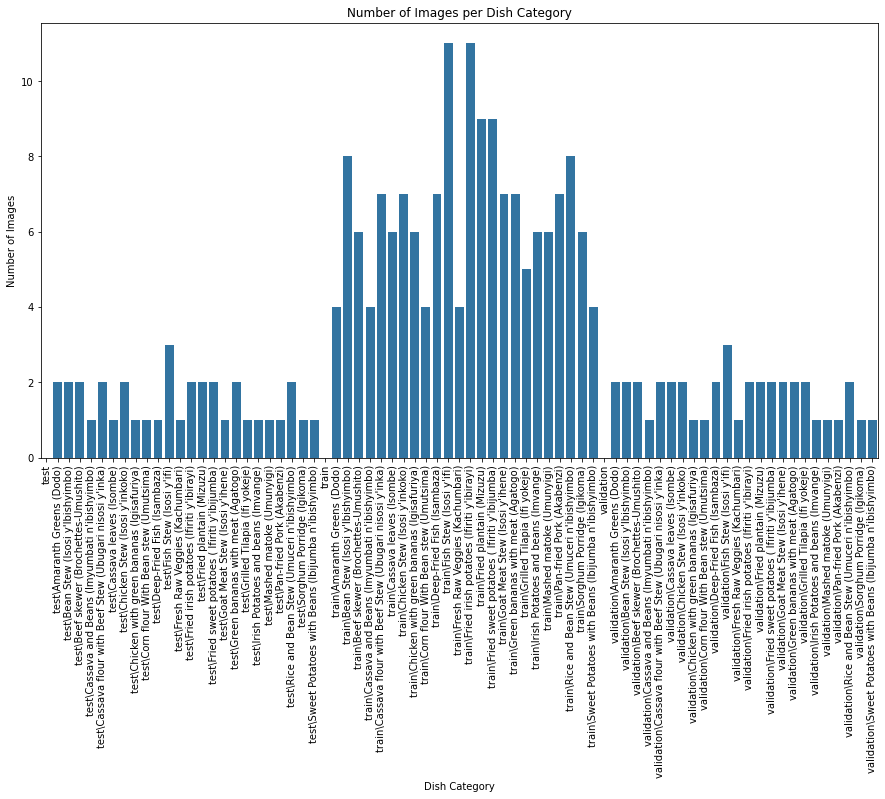

In [75]:
# 6. Image Dataset Analysis
def count_images_in_subfolders(directory):
    image_counts = {}
    for root, dirs, files in os.walk(directory):
        folder_name = os.path.relpath(root, directory)
        if folder_name != '.':
            image_count = len([f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))])
            image_counts[folder_name] = image_count
    return image_counts

image_counts = count_images_in_subfolders(DATA_DIR)

plt.figure(figsize=(15, 8))
sns.barplot(x=list(image_counts.keys()), y=list(image_counts.values()))
plt.title('Number of Images per Dish Category')
plt.xlabel('Dish Category')
plt.ylabel('Number of Images')
plt.xticks(rotation=90)
plt.show()

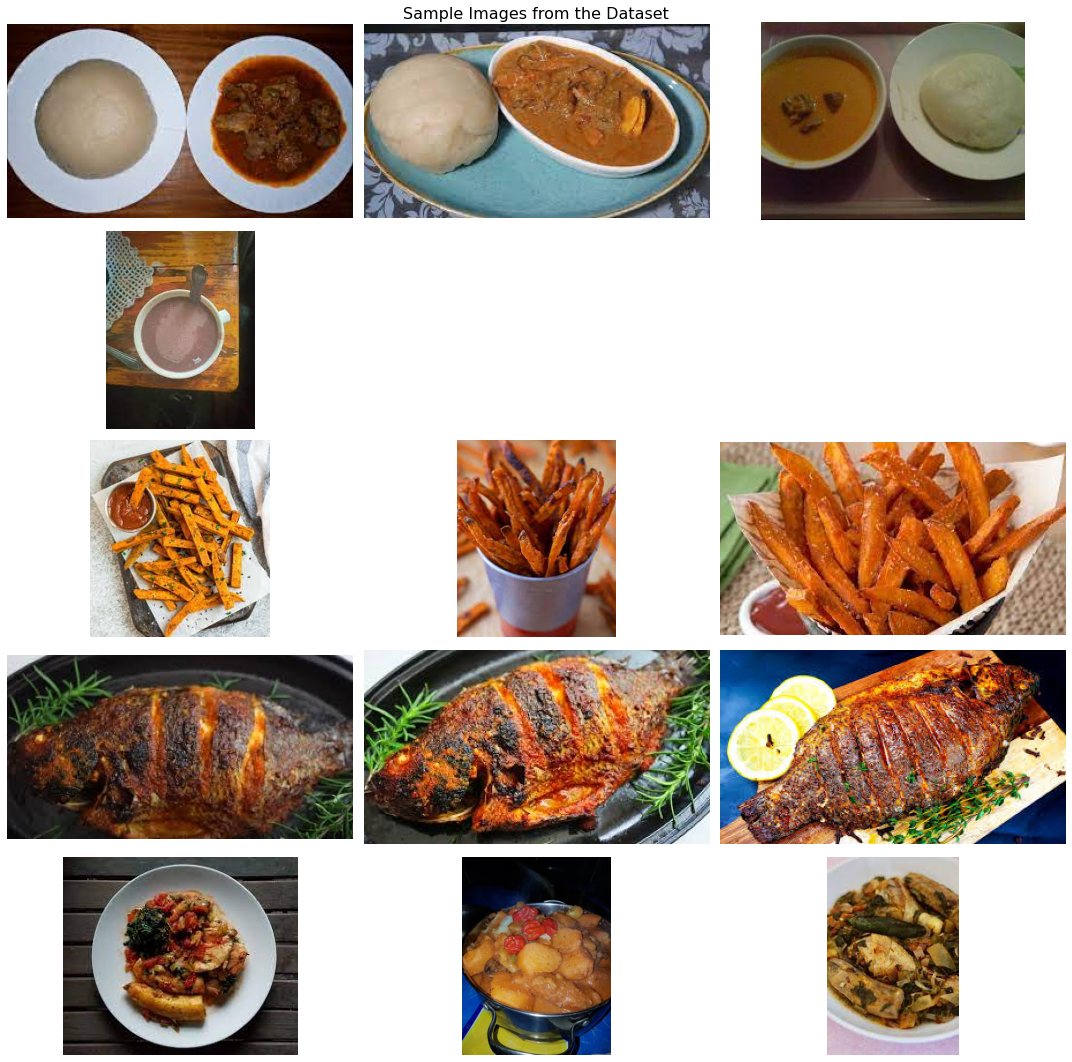

In [76]:
# 7. Sample Images Display
def display_sample_images(data_dir, num_dishes=5, images_per_dish=3):
    subfolders = ['train', 'validation', 'test']
    all_dish_folders = []
    for subfolder in subfolders:
        subfolder_path = os.path.join(data_dir, subfolder)
        dish_folders = [os.path.join(subfolder, f) for f in os.listdir(subfolder_path) if os.path.isdir(os.path.join(subfolder_path, f))]
        all_dish_folders.extend(dish_folders)
    
    num_dishes = min(num_dishes, len(all_dish_folders))
    sample_dishes = np.random.choice(all_dish_folders, num_dishes, replace=False)
    
    fig, axes = plt.subplots(num_dishes, images_per_dish, figsize=(15, 3*num_dishes))
    fig.suptitle('Sample Images from the Dataset', fontsize=16)
    
    if num_dishes == 1:
        axes = axes.reshape(1, -1)
    
    for i, dish_path in enumerate(sample_dishes):
        full_dish_path = os.path.join(data_dir, dish_path)
        images = [f for f in os.listdir(full_dish_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]
        
        images_to_display = min(images_per_dish, len(images))
        sample_images = np.random.choice(images, images_to_display, replace=False)
        
        for j, img_name in enumerate(sample_images):
            img_path = os.path.join(full_dish_path, img_name)
            img = Image.open(img_path)
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_ylabel(f"{os.path.basename(dish_path)}\n({os.path.dirname(dish_path)})", rotation=0, labelpad=50, va='center')
        
        for j in range(images_to_display, images_per_dish):
            axes[i, j].axis('off')
            axes[i, j].set_visible(False)
    
    plt.tight_layout()
    plt.show()

display_sample_images(DATA_DIR)

In [88]:
# Data Preprocessing and Augmentation
def preprocess_data(data_dir, target_size=(224, 224), batch_size=32):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        zoom_range=0.2,
        shear_range=0.2,
        fill_mode='nearest'
    )
    
    validation_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    train_generator = train_datagen.flow_from_directory(
        os.path.join(data_dir, 'train'),
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )
    
    validation_generator = validation_datagen.flow_from_directory(
        os.path.join(data_dir, 'validation'),
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    
    test_generator = test_datagen.flow_from_directory(
        os.path.join(data_dir, 'test'),
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    
    # Compute class weights
    y_train = train_generator.classes
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = dict(enumerate(class_weights))
    
    return train_generator, validation_generator, test_generator, class_weight_dict


In [89]:
# Improved Model Creation
def create_model(num_classes, input_shape=(224, 224, 3)):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Freeze the base model
    base_model.trainable = False
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model

In [90]:
# Training function with learning rate scheduling and early stopping
def train_model(model, train_generator, validation_generator, class_weight_dict, epochs=50):
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
    
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // validation_generator.batch_size,
        class_weight=class_weight_dict,
        callbacks=[early_stopping, reduce_lr]
    )
    
    return history

In [91]:
# Plotting functions
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


Found 159 images belonging to 24 classes.
Found 40 images belonging to 24 classes.
Found 36 images belonging to 24 classes.
Data preprocessing completed.
Number of training samples: 159
Number of validation samples: 40
Number of test samples: 36
Number of classes: 24
Epoch 1/50
4/4 [==============================] - 12s 2s/step - loss: 3.7567 - accuracy: 0.0391 - val_loss: 3.0900 - val_accuracy: 0.1562 - lr: 0.0010
Epoch 2/50
4/4 [==============================] - 7s 2s/step - loss: 3.1221 - accuracy: 0.0866 - val_loss: 2.9474 - val_accuracy: 0.1875 - lr: 0.0010
Epoch 3/50
4/4 [==============================] - 9s 2s/step - loss: 2.8225 - accuracy: 0.1496 - val_loss: 2.8492 - val_accuracy: 0.1562 - lr: 0.0010
Epoch 4/50
4/4 [==============================] - 8s 2s/step - loss: 2.7232 - accuracy: 0.1562 - val_loss: 2.6826 - val_accuracy: 0.2812 - lr: 0.0010
Epoch 5/50
4/4 [==============================] - 9s 2s/step - loss: 2.5706 - accuracy: 0.2578 - val_loss: 2.5489 - val_accuracy: 0

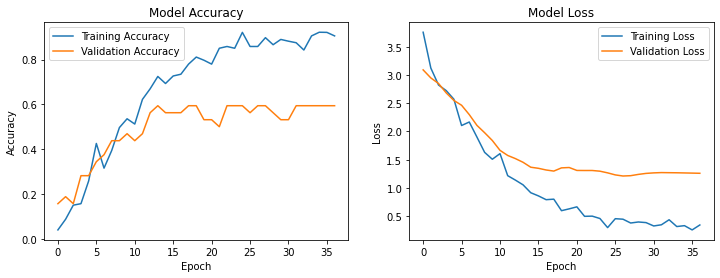

c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Model saved to c:\Users\User\Nutismart-WebApp\RwandanFoodAI\models\rwandan_food_model.h5
2/2 [==============================] - 2s 367ms/step - loss: 1.0674 - accuracy: 0.7500
Test accuracy: 0.75


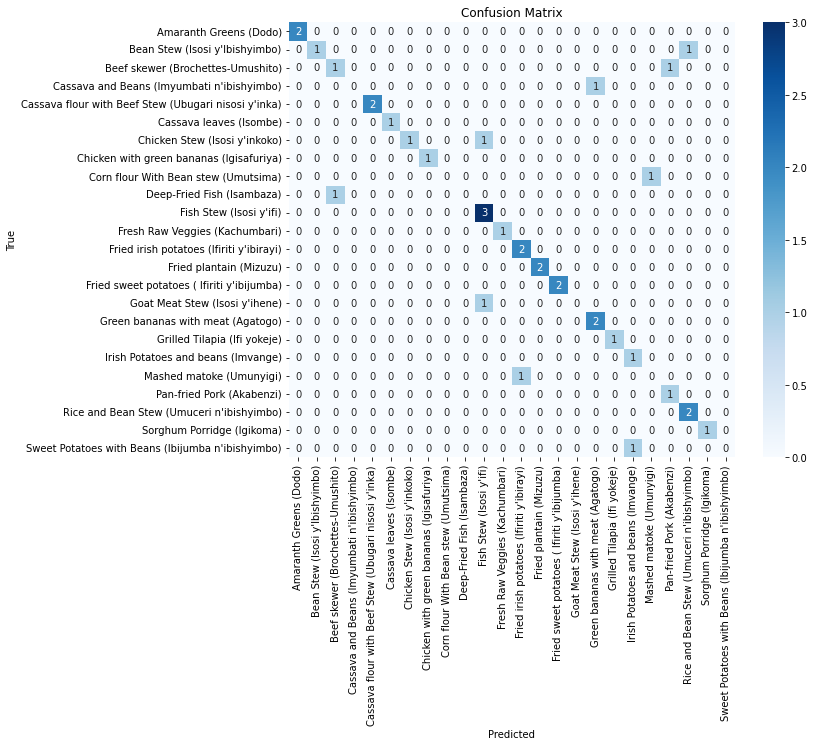

Predicted dish: Amaranth Greens (Dodo)
Actual dish: Amaranth Greens (Dodo)


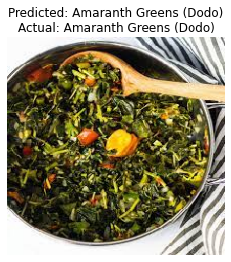


Nutritional Information:
Calories: 155
Protein: 9g
Carbs: 12g
Fat: 9g
Fiber: 9g

Similar dishes you might like:
- Cassava leaves (Isombe)
- Bean Stew (Isosi y'Ibishyimbo)
- Chicken with green bananas (Igisafuriya)
- Green bananas with meat (Agatogo)
- Fish Stew (Isosi y'ifi)


In [92]:
# Main execution
if __name__ == "__main__":
    # Data preprocessing
    train_generator, validation_generator, test_generator, class_weight_dict = preprocess_data(DATA_DIR)
    print("Data preprocessing completed.")
    print(f"Number of training samples: {train_generator.samples}")
    print(f"Number of validation samples: {validation_generator.samples}")
    print(f"Number of test samples: {test_generator.samples}")
    print(f"Number of classes: {len(train_generator.class_indices)}")
    
    # Model training
    num_classes = len(train_generator.class_indices)
    model = create_model(num_classes)
    history = train_model(model, train_generator, validation_generator, class_weight_dict)
    
    # Plot training history
    plot_training_history(history)
    
    # Save the model
    model.save(MODEL_PATH)
    print(f"Model saved to {MODEL_PATH}")
    
    # Evaluate on test set
    test_loss, test_accuracy = model.evaluate(test_generator)
    print(f"Test accuracy: {test_accuracy:.2f}")
    
    # Generate predictions for confusion matrix
    y_true = test_generator.classes
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Plot confusion matrix
    class_names = list(train_generator.class_indices.keys())
    plot_confusion_matrix(y_true, y_pred_classes, class_names)
    
    # Example prediction and recommendation
    test_images, test_labels = next(test_generator)
    predictions = model.predict(test_images)
    predicted_class = np.argmax(predictions[0])
    true_class = np.argmax(test_labels[0])
    
    predicted_dish = class_names[predicted_class]
    true_dish = class_names[true_class]
    
    print(f"Predicted dish: {predicted_dish}")
    print(f"Actual dish: {true_dish}")
    
    # Display the sample image
    plt.imshow(test_images[0])
    plt.title(f"Predicted: {predicted_dish}\nActual: {true_dish}")
    plt.axis('off')
    plt.show()
    
    # Nutritional information
    dish_info = df[df['name'] == predicted_dish].iloc[0]
    print("\nNutritional Information:")
    print(f"Calories: {dish_info['total_calories']}")
    print(f"Protein: {dish_info['protein']}g")
    print(f"Carbs: {dish_info['carbs']}g")
    print(f"Fat: {dish_info['fat']}g")
    print(f"Fiber: {dish_info['fiber']}g")
    
    # Simple recommendation based on similar nutritional content
    df['similarity'] = df[['protein', 'carbs', 'fat', 'fiber']].apply(lambda row: cosine_similarity([row], [dish_info[['protein', 'carbs', 'fat', 'fiber']]])[0][0], axis=1)
    recommendations = df.sort_values('similarity', ascending=False).iloc[1:6]['name'].tolist()
    
    print("\nSimilar dishes you might like:")
    for dish in recommendations:
        print(f"- {dish}")